## Imporatación de las librerías

In [1]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

#Resultados
import shap

## Lectura datos UH_2023_TRAIN

In [26]:
uh_2023_df = pd.read_csv('/kaggle/input/cajamar-malbec/UH_2023/UH_2023_TRAIN.txt', sep= '|', header=0 )
uh_2023_df.columns = [col.lower().replace('-','_') for col in uh_2023_df.columns]
uh_2023_df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


In [27]:
print(f'Número de filas: {uh_2023_df.shape[0]}, Número de columnas:{uh_2023_df.shape[1]}')
print(f'\nCantidad de duplicados: {uh_2023_df.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(uh_2023_df.dtypes)
print('\n -------- Cantidad de nulos --------')
uh_2023_df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

-------- Tipos de columnas --------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object

 -------- Cantidad de nulos --------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

## Transformaciones

**Altitud**

In [28]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [29]:
uh_2023_df['altitud'] = uh_2023_df['altitud'].apply(lambda alt: transform_altitud(alt))
uh_2023_df.describe()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
count,9601.00,9601.00,9601.00,9601.00,9547.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,577.85,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,76.49,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,370.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,490.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,610.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,635.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,820.00,94.00,2.00,1.00,1.00,26.85,177520.00


## División del dataset

Sacamos el año 2021 como conjunto de **test**.

Este presenta nulos en la altitud, se debe tener en cuenta.

In [30]:
test_2021_df = uh_2023_df[uh_2023_df['campaña'] == 21]
print(test_2021_df.shape)
test_2021_df.isna().sum()

(1044, 11)


campaña        0
id_finca       0
id_zona        0
id_estacion    0
altitud        6
variedad       0
modo           0
tipo           0
color          0
superficie     0
produccion     0
dtype: int64

In [31]:
train_df_with_2022 = uh_2023_df[uh_2023_df['campaña'] != 21]
print(train_df_with_2022.shape)
train_df_with_2022.isna().sum()

(8557, 11)


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          48
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

## Tratamiento NA

**Variable Altitud en TRAIN**

In [32]:
train_df_with_2022[train_df_with_2022.altitud.isnull()].shape

(48, 11)

In [33]:
mean_altitudes_train = pd.DataFrame(train_df_with_2022.groupby('id_estacion')['altitud'].mean()).reset_index()
df_altitud = train_df_with_2022.merge(mean_altitudes_train, how='left', on='id_estacion')
df_altitud['altitud'] = df_altitud.altitud_x.fillna(df_altitud.altitud_y)
df_altitud.drop(columns=['altitud_x','altitud_y'], inplace=True)
train_df_with_2022 = df_altitud.copy()
train_df_with_2022[train_df_with_2022.altitud.isnull()].shape

(0, 11)

**Variable altitud en TEST**

In [34]:
mean_altitudes_test = pd.DataFrame(test_2021_df.groupby('id_estacion')['altitud'].mean()).reset_index()
df_altitud = test_2021_df.merge(mean_altitudes_test, how='left', on='id_estacion')
df_altitud['altitud'] = df_altitud.altitud_x.fillna(df_altitud.altitud_y)
df_altitud.drop(columns=['altitud_x','altitud_y'], inplace=True)
test_2021_df = df_altitud.copy()
test_2021_df[test_2021_df.altitud.isnull()].shape

(0, 11)

**Variable superficie en TRAIN**

Hay superficies que están a 0 y que deben de ser imputadas

In [35]:
train_df_with_2022['superficie'] = train_df_with_2022['superficie'].replace(0, np.nan)
train_df_with_2022[train_df_with_2022['superficie'].isnull()].shape

(6498, 11)

Vamos cubriendo los NAs segun por menor a mayor jerarquia

In [36]:
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022.superficie.isna().sum()

0

**Variable superficie en TEST**

In [43]:
test_2021_df['superficie'] = test_2021_df['superficie'].replace(0, np.nan)
test_2021_df[test_2021_df['superficie'].isnull()].shape

(20, 11)

In [44]:
test_2021_df['superficie'] = test_2021_df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
test_2021_df['superficie'] = test_2021_df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
test_2021_df.superficie.isna().sum()

0

## Mutual Information with production

Quitamos el 2022 ya que no tiene datos de producción y probamos mutual information

In [45]:
train_df_without_2022 = train_df_with_2022[train_df_with_2022['campaña'] != 22]
print(train_df_without_2022.shape)
train_df_without_2022.isna().sum()

(7482, 11)


campaña        0
id_finca       0
id_zona        0
id_estacion    0
variedad       0
modo           0
tipo           0
color          0
superficie     0
produccion     0
altitud        0
dtype: int64

In [46]:
categorical_vars, continous_vars, target = list(train_df_without_2022.columns)[:-3], ['superficie', 'altitud'], ['produccion'] 
print(categorical_vars, continous_vars, target)
train_df_without_2022_copy = train_df_without_2022.copy() 

['campaña', 'id_finca', 'id_zona', 'id_estacion', 'variedad', 'modo', 'tipo', 'color'] ['superficie', 'altitud'] ['produccion']


In [47]:
label_encoder = LabelEncoder()
for categorical_var in categorical_vars:
    train_df_without_2022_copy[categorical_var] = label_encoder.fit_transform(train_df_without_2022_copy[categorical_var])

In [48]:
train_df_without_2022_copy.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,altitud
0,0,897,66,4,7,1,0,1,2.72,22215.00,660.00
1,0,976,66,4,7,1,0,1,2.72,22215.00,660.00
2,0,997,38,4,8,1,0,1,2.94,20978.00,520.00
3,0,803,38,4,8,1,0,1,2.94,40722.00,520.00
4,0,169,104,14,20,0,0,1,2.79,14126.00,658.75


Calculamos el mutual information para cada variable con respecto a la target continua.

In [49]:
discrete_vars = [True, True, True, True, True, True, True, True, False, False]
mutual_info = mutual_info_regression(train_df_without_2022_copy.drop(columns=['produccion']),
                                     train_df_without_2022_copy.produccion, discrete_features=discrete_vars)

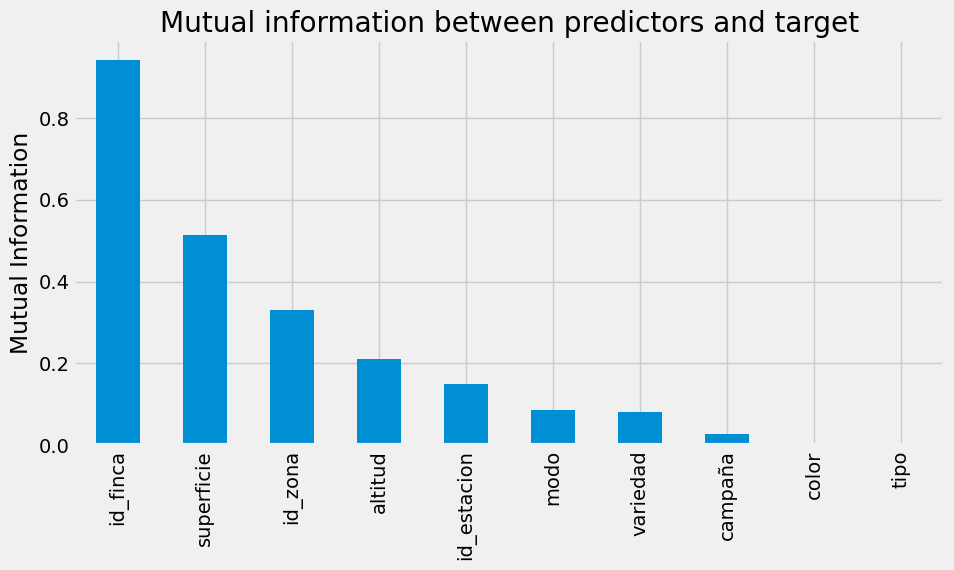

In [50]:
mutual_info_df = pd.Series(mutual_info)
mutual_info_df.index = train_df_without_2022_copy.drop(columns=['produccion']).columns
mutual_info_df.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")
plt.show()

## Búsqueda de modelos iniciales